In [1]:
%%time

#Modded from qutip to allow parallelism
import numpy as np
import scipy.linalg as la
from numpy import angle, pi
from qutip import Qobj, propagator

def floquet_modes_mod(H, T, args=None, parallel=False, sort=False, U=None):
    """
    Calculate the initial Floquet modes Phi_alpha(0) for a driven system with
    period T.

    Returns a list of :class:`qutip.qobj` instances representing the Floquet
    modes and a list of corresponding quasienergies, sorted by increasing
    quasienergy in the interval [-pi/T, pi/T]. The optional parameter `sort`
    decides if the output is to be sorted in increasing quasienergies or not.

    Parameters
    ----------

    H : :class:`qutip.qobj`
        system Hamiltonian, time-dependent with period `T`

    args : dictionary
        dictionary with variables required to evaluate H

    T : float
        The period of the time-dependence of the hamiltonian. The default value
        'None' indicates that the 'tlist' spans a single period of the driving.

    U : :class:`qutip.qobj`
        The propagator for the time-dependent Hamiltonian with period `T`.
        If U is `None` (default), it will be calculated from the Hamiltonian
        `H` using :func:`qutip.propagator.propagator`.

    Returns
    -------

    output : list of kets, list of quasi energies

        Two lists: the Floquet modes as kets and the quasi energies.

    """
    if 'opts' in args:
        options = args['opts']
    else:
        options = Options()
        options.rhs_reuse = True
        rhs_clear() 
    
    if U is None:
        # get the unitary propagator
        U = propagator(H, T, [], args, parallel=parallel, progressbar=True, options=options)
    
    # find the eigenstates for the propagator
    evals, evecs = la.eig(U.full())

    eargs = angle(evals)

    # make sure that the phase is in the interval [-pi, pi], so that
    # the quasi energy is in the interval [-pi/T, pi/T] where T is the
    # period of the driving.  eargs += (eargs <= -2*pi) * (2*pi) +
    # (eargs > 0) * (-2*pi)
    eargs += (eargs <= -pi) * (2 * pi) + (eargs > pi) * (-2 * pi)
    e_quasi = -eargs / T

    # sort by the quasi energy
    if sort:
        order = np.argsort(-e_quasi)
    else:
        order = list(range(len(evals)))

    # prepare a list of kets for the floquet states
    new_dims = [U.dims[0], [1] * len(U.dims[0])]
    new_shape = [U.shape[0], 1]
    kets_order = [Qobj(np.matrix(evecs[:, o]).T,
                       dims=new_dims, shape=new_shape) for o in order]

    return kets_order, e_quasi[order]

CPU times: user 1.82 s, sys: 267 ms, total: 2.09 s
Wall time: 2.64 s


/usr/local/anaconda3/anaconda3/lib/python3.9/site-packages/qutip/configrc.py:294: UserWarning: Invalid qutip config variable in qutiprc: num_cpus
  warnings.warn("Invalid qutip config variable in qutiprc: "


# Introduction

Dynamical Freezing (DMF) is a phenomenon whereby periodically driven Many Body Systems are prevented from thermalizing to infinite temperature due to a dynamical hysteresis that prevents observables from reaching their diagonal averaged values.

DMF can, under certain resonance conditions in the drive parameters, cause the response to ‘freeze’ completely to its initial value for all times. This has been demonstrated (via the Jordan-Wigner Transformation) in the driven TFIM with nearest neighbour interactions, and is shown to be protected when translational invariance is explicitly broken (say, by disorder). 

We have suspected that this is also protected against the loss of other symmetries, for example, in long range systems where JW transformation produces nonlocalities. To prove this, we introduce a long-range power law dependence in the TFIM, where the exchange $J_{ij}\sim 1/|i-j|^\beta$. Here, for $\beta=\infty$, we recover the short range TFIM and freezing at resonant drive parameters. When $\beta=0$, taking $N\rightarrow\infty$ allows us to describe the exact dynamics by the periodically driven Lipkin-Meshkov-Glick (LMG) model, which we have solved numerically to obtain a similar kind of DMF and ‘freezing’ as the$\beta=\infty$ case.

Now, we compare the degree of localization of the quasi-stationary Floquet modes in both cases. In order to do so, we look at the Inverse Participation Ratios (IPR) of the modes in the representation given by the eigenstates of the symmetry-breaking field. 

What we're seeing is that there appears to be a high degree of localization in the TFIM case, as consistent with analytical treatments using the Rotated Wave Approximation (RWA), where only the slowest rotating terms in the Fourier expansion of the Hamiltonian in a frame co-rotating with the symmtry-breaking driving field are retained. 

However, the degree of localization in the LMG model is much lower, with the RWA breaking down substantially, requiring higher order terms in the expansion for agreement with numerical simulations. These terms cause the unperturbed (and localized) Floquet states to mix, reducing the localization noticeably.


## Background
A generic interacting quantum many body system, if driven time-periodically for a sufficiently long time, is expected to follow a dynamical route to thermalization at infinite temperature. This can be demonstrated by the Eigenstate Thermalization Hypothesis (ETH), where long-time averages of observables, resolved in the basis of stationary states, approach the average predicted by the microcanonical ensemble. 

For instance, if the stationary states are expressed by $|e_i\rangle$, with corresponding eigenvalues $e_i$ of Hamiltonian $H$, then the time-evolution of an observable $O$ on a closed isolated quantum system starting from $|\psi_0\rangle$ at $t=0$ is
\begin{align*}
\langle O (t) \rangle &= \langle e^{iHt}Oe^{-iHt}\rangle\\
                      &= \sum_{ij}e^{-i\big(e_i-e_j\big)t} O_{ij} \langle\psi_0|e_i\rangle \langle e_j|\psi_0\rangle.
\end{align*}
The time-average of this expectation, averaged over very long times and non-degenerate $e_i$, is expected to be
\begin{align*}
\overline{\langle O (t) \rangle} &= \sum_{ij}\overline{e^{-i\big(e_i-e_j\big)t}}O_{ij} \langle\psi_0|e_i\rangle \langle e_j|\psi_0\rangle\\
 &= \sum_{ij}\delta_{ij}O_{ij} \langle\psi_0|e_i\rangle \langle e_j|\psi_0\rangle\\
 &=\sum_i O_{ii}\bigg\vert \langle e_i\vert\psi_0\rangle \bigg\vert^2,
\end{align*}
Thus, after a long time, $\overline{O}$ reaches a diagonal average that, under the conditions of ETH, should thermalize. However, a high degree of degeneracy in the eigenvalues $e_i$ will prevent some of the $\overline{e^{-i\big(e_i-e_j\big)t}}$-terms from reaching $\delta_{ij}$. In the extreme case when all the eigenvalues are equal, the diagonal average values are dynamically suppressed, leading to **Dynamical Many Body Localization** or **Many Body Freezing**. We want to look at localization of Floquet eigenstates in this regime.

# Investigation of IPR in the Floquet Dynamics of Many Body Systems

We're trying to look at localization/freezing in rapidly driven time-periodic systems. Specifically, we want to check whether freezing exists in long raange spin systems in the manner seen for short range systems. We start by defining the *Inverse Participation Ratio* (IPR) for a wavefunction $\psi(x)$ as 
\begin{equation*}
\phi_{IPR}\equiv \int dx\;\vert\psi(x)\vert^4
\end{equation*}

More generally, the IPR of a state $|\phi\rangle$ in a representation given by complete orthonormal basis $|m\rangle$ is $\phi_{IPR} = \sum_m\vert\langle m \vert\phi\rangle\vert^4$.

In the context of localization, the IPR is useful. The smallest value of the IPR corresponds to a fully delocalized state, $\psi(x)=1/\sqrt{N}$ for a system of size $N$, where the IPR yields $\sum_x |\psi(x)|^4=N/(N^{1/2})^4=1/N$. Values of the IPR close to 1 correspond to localized states. For a periodically driven system, we look at the IPR of the Floquet modes at $t=T$, where $t=2\pi/\omega$ for drive frequency $\omega$.

## Transverse-Field Ising model.
First, consider the well-known Hamiltonian of the driven Transverse Field Ising model of $N$ spins:
\begin{align*}
 H(t) &= H_0 + \left(h_0 + h\cos{\omega t}\right) H_1\\
H_0 &= -\frac{1}{2}\sum_{i} \sigma^x_i \sigma^x_{i+1}\\
H_1 &= -\frac{1}{2}\sum_n^N \sigma^z_{n}
\end{align*}

The TFIM model can be readily transformed into a Bogoliubov-type fermionic system via the Jordan-Wigner transformation. This yields an effective Hamiltonian

\begin{equation*}
\mathcal{H}(t)=\sum_{{k, -k}} \psi_{{k}}^{\dagger}\left(\begin{array}{cc}
h_{z}(t)+f_{{k}} & \Delta_{{k}} \\
\Delta_{{k}}^{*} & -h_{z}(t)-f_{{k}}
\end{array}\right) \psi_{{k}},
\end{equation*}

where $h_z(t) = h_0 + h\cos{\omega t}$, $\psi_k = (c_{-k}, c^\dagger_k)^T$, with $f_k = J\cos{k}$, $\Delta_k = J\sin{k}$. We can rewrite

\begin{equation*}
H(t) = \sum_{k,-k} \psi^\dagger_k
\Big[\sigma_z f_k + \sigma_x \Delta_k + \sigma_z h_z(t)\Big]\psi_k
\end{equation*}

For a particular $k,-k$ pair, let us define the undriven part $H_0(k) = \sigma_z f_k + \sigma_x \Delta_k$ and $H_1 = \sigma_z$, yielding 
$H_k(t) = H_0(k) + h\cos{\omega t}\; H_1$. Now, we transform to the rotated frame via the unitary transformation operator $U = e^{i\int H_d d t} = exp \Big[\frac{i h}{\omega}\sin{\omega t}\Big]\sigma_z$. This yields
\begin{align*}
H^\prime_k(t) &= U^\dagger H_0(k) U \\
&=e^{-i\frac{h}{\omega}\sin{\omega t}\sigma_z} H_0(k) e^{i\frac{h}{\omega}\sin{\omega t}\sigma_z}\\
\end{align*}


If we define defined $\eta=2h/\omega$, then
\begin{align*}
H^\prime_k(t) &= \begin{pmatrix}e^{-i\frac12\eta\sin{\omega t}}&0\\0&e^{i\frac12\eta\sin{\omega t}}\end{pmatrix} \begin{pmatrix}f_k&\Delta_k\\\Delta_k &-f_k\end{pmatrix}\begin{pmatrix}e^{i\frac12\eta\sin{\omega t}}&0\\0&e^{-i\frac12\eta\sin{\omega t}}\end{pmatrix}\\
&= \begin{pmatrix}f_k&e^{i\eta\sin{\omega t}}\Delta_k\\e^{-i\eta\sin{\omega t}}\Delta_k&-f_k\end{pmatrix}\\
&=  \sigma^z f_k + 2\sigma^x \Delta_k \sum_{n\geq 0} J_{2n}(\eta)\cos{\big(2n\omega t\big)} - 2\sigma^y\Delta_k \sum_{n\geq 0} J_{2n+1}(\eta)\sin{\bigg[\big(2n+1\big)\omega t\bigg]}
\end{align*}
Here, in the last step, have used the Jacobi-Anger formula $e^{i \eta \sin{\omega t}} \equiv \sum_{n=-\infty}^{\infty} J_n(\eta)\, e^{i n \omega t}$. Now, for large $\omega \gg f_k$, the RWA approximation allows us to replace $H^\prime_k(t)$ by it's long-time average, leaving behind only the non-oscillating modes in the expansion above, an effective Hamiltonian [1]
\begin{equation*}
H^{(RWA)}_k=f_k \sigma^z + 2 J_0(\eta)\Delta_k\sigma^x.
\end{equation*}
Clearly, if we adjust drive parameters such that $\eta$ lies on a root of $J_0(\eta)$, then $\sigma^z$ becomes a conserved quantity. A particular Floquet mode of the Hamiltonian can, in general, be written as $|\phi\rangle = \prod_{k,-k}|\phi^n_k\rangle$. In the RWA limit and in the regime where $J_0(\eta)$ vanishes, $|\phi^n_k\rangle$ has values of $|0\rangle, |k,-k\rangle$ for two values of $n=0,1$ respectively.

We define the reduced IPR of $|\phi^n_k\rangle\; \forall k$ to be
\begin{equation*}
\phi^{(n)}_{IPR}(k) = \left\vert \langle 0 |\phi^n_k\rangle  \right\vert^4 + \left\vert \langle +k, -k |\phi^n_k\rangle  \right\vert^4,
\end{equation*}
where $n=0,1$. In the RWA limit, when $J_0(eta)$ vanishes, this quantity is unity, indicating low participation and high degree of localization.


The code cell below plots $\phi^n_{IPR}(k)$ for the full exact dynamics.



## References:

[1] Das, A. arXiv:0904.2172 (2009)

In [2]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, mesolve 
from qutip.floquet import floquet_modes
from scipy.special import j0

def drive(t, args):
    h0 = args['h0']
    h = args['h']
    w = args['omega']
    return h0 + h * np.cos(w * t)

def get_floquet_isingfermion(k, args, **kwargs):
    
    sx = sigmax()
    sz = sigmaz()
    
    # construct the hamiltonian
    H0 = np.sin(k) * sx + np.cos(k) * sz
    H1 = sz
    
    H = [H0,[H1,drive]]    
    T = 2 * np.pi/args['omega']

    return floquet_modes(H, T, args, **kwargs)

def get_iprvals_exact(k, params, **kwargs):
    f_states, f_energies = get_floquet_isingfermion(k, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 53 µs, sys: 0 ns, total: 53 µs
Wall time: 59.1 µs


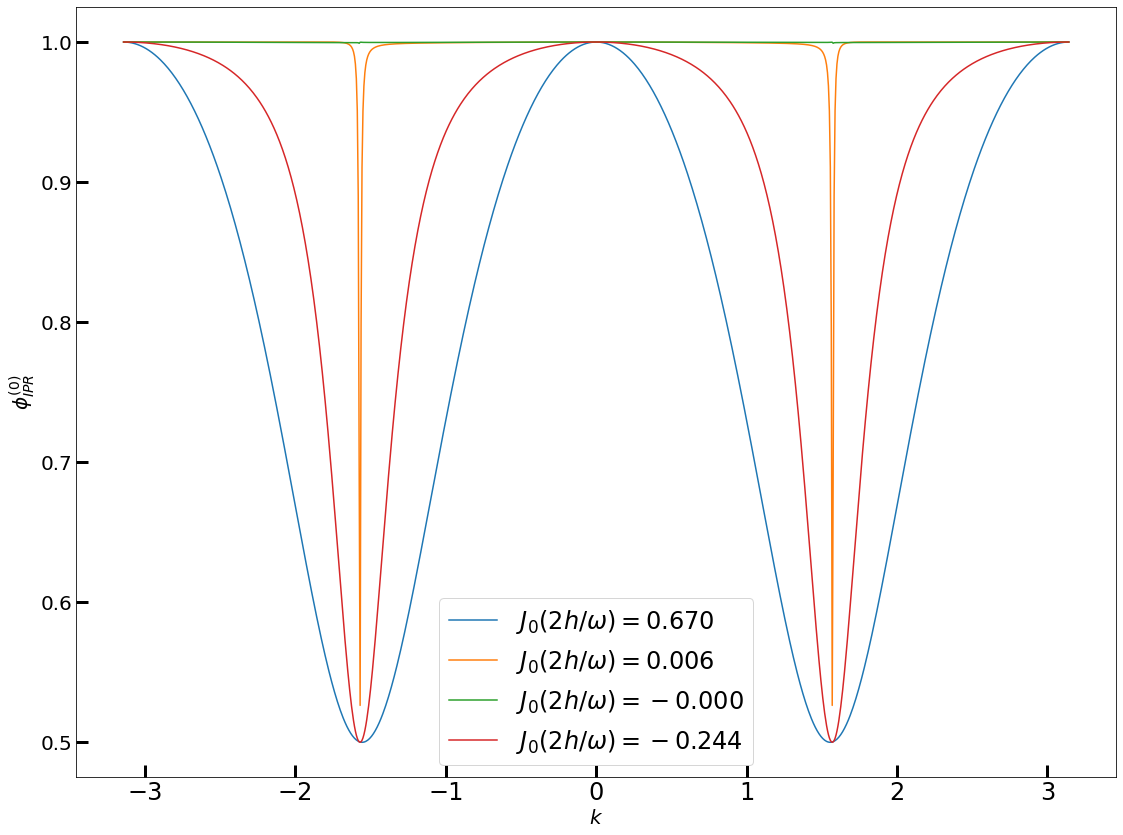

CPU times: user 11.2 s, sys: 3.97 ms, total: 11.2 s
Wall time: 11.2 s


In [14]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros
from tqdm import tqdm
import traceback

plt.rcParams.update({
    "figure.figsize": (16, 12),
    "text.usetex": False,
    "font.size": 20})

freezing_pts = jn_zeros(0, 5)
max_pts = jn_zeros(1,5)

#
# set up the calculation
#
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2
hmed = 0.995 * omega * freezing_pts/2
hmax = 1.25 * omega * max_pts/2
hfin = 0.5 * omega * freezing_pts/2


delta = 1e-4
fbz = np.linspace(-np.pi+delta, np.pi-delta, 1000)

for h in np.sort([hfrz[0], hmed[0], hmax[0], hfin[0]]):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    iprvals_exact = np.array([get_iprvals_exact(k, params, sort=True) for k in fbz])
    plt.plot(fbz, iprvals_exact[:,0], label=fr"$J_0(2h/\omega)={j0(2*h/w):1.3f}$")

plt.ylabel(f'$\phi^{{({{0}})}}_{{IPR}}$')
plt.xlabel(r'$k$')
plt.legend()

plt.show()

In [4]:
%%time
import numpy as np
from tqdm import tqdm
from scipy.special import jn_zeros

freezing_points = jn_zeros(0,3)

#
# set up the calculation
#
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2

delta = 1e-7
fbz = np.linspace(-np.pi+delta, np.pi-delta, 100)
hvals = np.linspace(0.0, 7*omega, 200)
#include freezing points
hvals = np.sort(np.append(hvals, hfrz))

iprmat = np.empty([len(hvals), len(fbz)])
for x, h in tqdm(enumerate(hvals)):
    params = {'h0':0.0, 'h':h, 'omega':omega}
    iprvals_exact = np.array([get_iprvals_exact(k, params, sort=True) for k in fbz])
    iprmat[x,:] = iprvals_exact[:,0]

204it [02:50,  1.20it/s]

CPU times: user 2min 50s, sys: 372 ms, total: 2min 50s
Wall time: 2min 50s


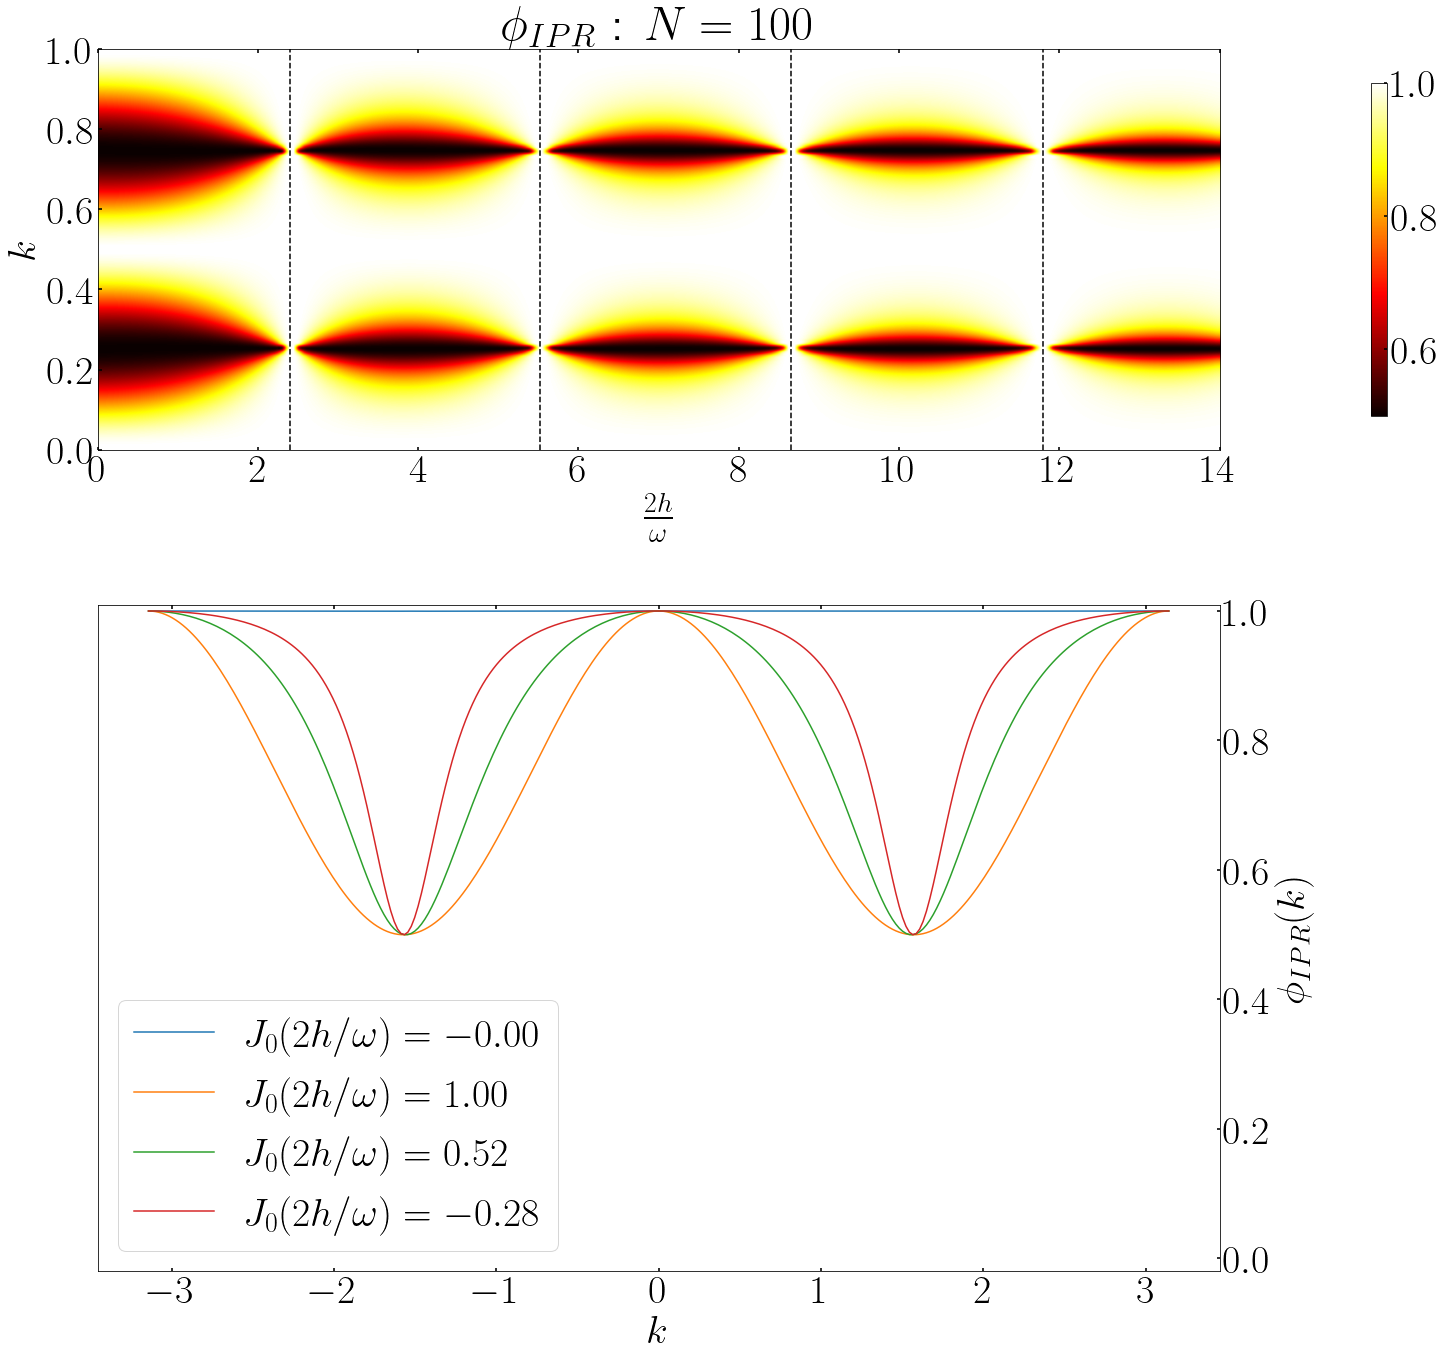

In [5]:
import matplotlib.pyplot as plt
from scipy.special import j0,jn_zeros
from scipy.interpolate import make_interp_spline

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})

freezing_pts = jn_zeros(0,4)

etas = 2 * hvals/w

fig = plt.figure(tight_layout=False, constrained_layout=True)

ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {len(fbz)}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{2h}{\omega}$')
ipr_ax.set_ylabel(r'$k$')


im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

for pt in freezing_pts:
    ipr_ax.axvline(pt, color='black', ls='--')

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.5)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[0], atol=1e-3))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.09))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 4.8, atol=0.2))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = fbz
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    crosssec_ax.plot(xnew, gfg(xnew), label=fr"$J_0(2h/\omega)={j0(etas[n]):1.2f}$")


crosssec_ax.set_xlabel(r"$k$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(k)$")
crosssec_ax.set_ylim(-0.02, 1.01)
plt.legend()
#plt.savefig("ising_ipr.png", dpi=200)
plt.show()

The plots above are for the **exact** dynamics of the TFIM in Fermionic representation, with the reduced IPR plotted for the entire Brillouin zone for a few drive amplitudes. The frequency is set to $\omega = 90$ and the IPR of one of the two Floquet modes are plotted at time $t=T$ for $4$ chosen amplitudes. As can be seen, the exact result is consistent with the RWA approximation. When $J_0(2h/\omega) = 0$, the RWA Hamiltonian vanishes, yielding an IPR of unity. At other points, the IPR is unity only when $k=\pm \pi$ (since $\Delta_k=0$) and $k=0$ (since $f_k = 0$ and the Hamiltonian for each $k$ $\sim \sigma_x$); other than that, there is "delocalization" due to the ensuing dynamics.

Finally, let us look at quantitative comparisons between the exact result and the RWA result.  We compare IPR's of the Floquet modes obtained with the zeroth and first order terms in the RWA expansion with the exact case. The three Hamiltonians whose Floquet modes are to be compared are
\begin{align*}
H_k(t) &= \sigma_z f_k + \sigma_x \Delta_k + \sigma_z h\cos{\omega t}\\
H^{(RWA)}_k(t) &= \sigma_z f_k + 2 J_0(\eta) \sigma^x \Delta_k\\
H^{(RWA2)}_k(t) &= H^{(RWA)}_k(t) - 2 J_1(\eta)\Delta_k \sigma^y\;\sin{\big(\omega t\big)}. 
\end{align*}
with $\eta=2 h/\omega$. 

In [3]:
%%time
import numpy as np
from qutip import tensor, sigmax, sigmay, sigmaz, qeye, propagator 
from qutip.floquet import floquet_modes
from scipy.special import jn

def drive_sx_rwa(t, args):
    n = args['order']
    w = args['omega']
    h = args['h']
    eta = 2*h/w
    cos_indices = np.arange(0,n+1,2)
        
    return np.sum([jn(m, eta)*np.cos(m*w*t) for m in cos_indices])

def drive_sy_rwa(t, args):
    n = args['order']
    w = args['omega']
    h = args['h']
    eta = 2*h/w
    sin_indices = [0]
    if n != 0:
        if n == 1:
            sin_indices = [0,1]
        else:
            sin_indices = np.arange(1,n+1,2)          
    return np.sum([jn(m, eta)*np.sin(m*w*t) for m in sin_indices])

def get_floquet_isingfermion_RWA(k, args, **kwargs):
    h = args['h']
    w = args['omega']
    eta = 2*h/w
    Dk = np.sin(k) 
    fk = np.cos(k)
    n = args['order']
    sx, sy, sz = sigmax(), sigmay(), sigmaz()
    H_rwa = sz * fk + 2 * j0(eta) * Dk * sx
    H = [H_rwa, [2 * Dk * sx, drive_sx_rwa] ,[-2 * Dk * sy, drive_sy_rwa]]
    
    T = 2 * np.pi/w
    return floquet_modes_mod(H, T, args, **kwargs)

def get_iprvals_RWA(k, params, **kwargs):
    f_states, f_energies = get_floquet_isingfermion_RWA(k, params, **kwargs)
    floquet_matrix = np.array(f_states)[:,:,0]
    return np.sum(np.abs(floquet_matrix)**4, axis=-1)

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 31.5 µs


Running with  15  processors for N =  75  order =  exact


205it [00:51,  3.95it/s]


Running with  15  processors for N =  75  order =  0


205it [00:52,  3.88it/s]


Running with  15  processors for N =  75  order =  1


205it [01:02,  3.27it/s]


Running with  15  processors for N =  75  order =  3


205it [01:17,  2.63it/s]


Running with  15  processors for N =  75  order =  5


205it [01:41,  2.02it/s]


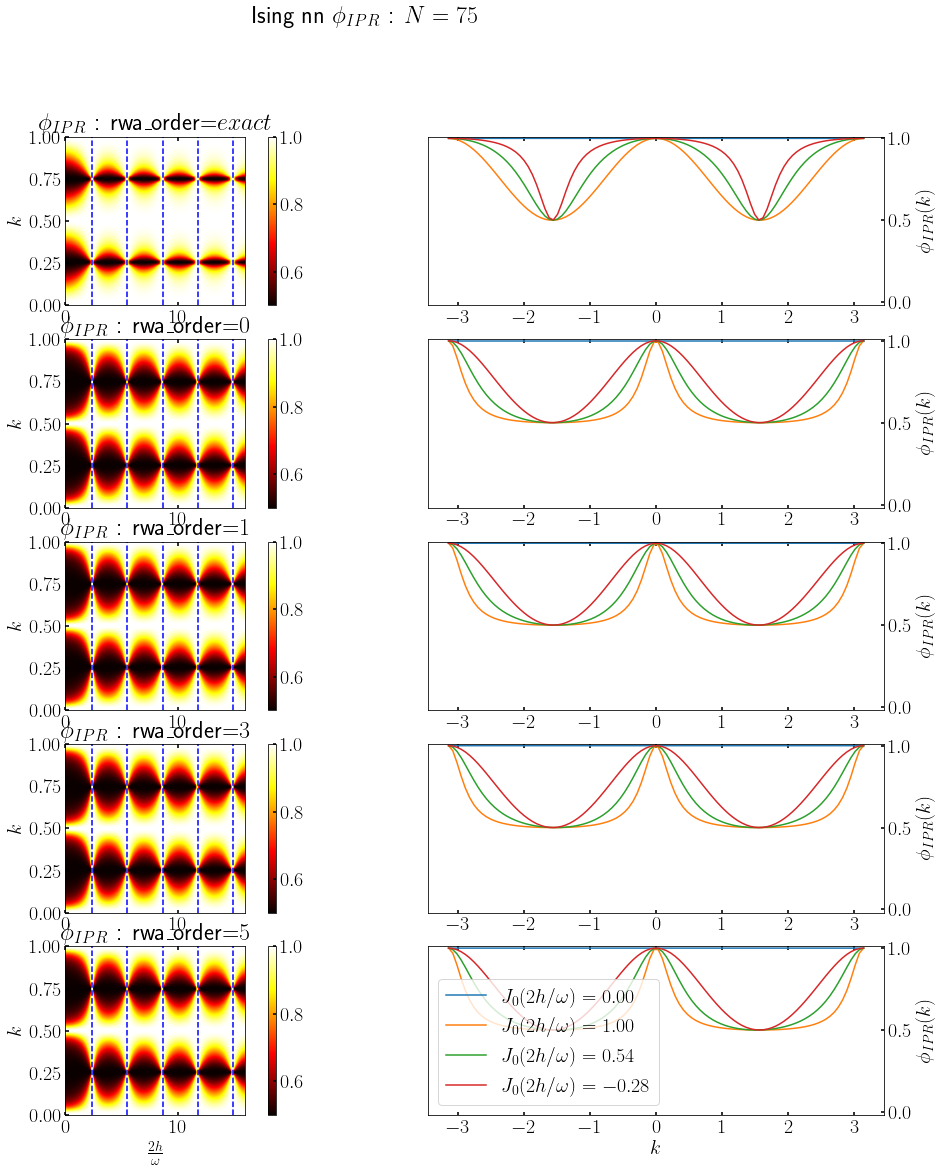

CPU times: user 55.5 s, sys: 1min 47s, total: 2min 43s
Wall time: 5min 53s


In [5]:
%%time
import numpy as np
from tqdm import tqdm
from scipy.special import jn_zeros
from qutip import Options, parfor
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

plt.rcParams.update({"figure.figsize": (12,18),"text.usetex": True,
    "font.family": "sans-serif","font.size": 20,"font.sans-serif": ["Computer Modern"]})

cpus = 15
size = 75
orders = ['exact',0, 1, 3, 5]

freezing_pts = jn_zeros(0,5)
omega = 90.0
w = omega
hfrz = omega * freezing_pts/2

delta = 1e-7
fbz = np.linspace(-np.pi+delta, np.pi-delta, size)
hvals = np.linspace(0.0,  omega/2 * 16.0, 200)
hvals = np.sort(np.append(hvals, hfrz))

opts = Options(rhs_reuse=False)
fig, axs = plt.subplots(len(orders), 2, figsize=(18,18))
fig.suptitle(fr'Ising nn $ \phi_{{IPR}}$ : $N = {len(fbz)}$')
  

for i,order in enumerate(orders):
    print('Running with ', cpus, ' processors for N = ', size ,' order = ', order)
    iprmat = np.empty([len(hvals), len(fbz)])
    
    for x, h in tqdm(enumerate(hvals)):
        params = {'h0':0.0, 'h':h, 'omega':omega, 'order':order, 'opts':opts}
        if order == 'exact':
            iprvals = np.array(parfor(get_iprvals_exact,fbz, [params]*size, sort=False, num_cpus=cpus))
        else:
            iprvals = np.array(parfor(get_iprvals_RWA,fbz, [params]*size, sort=False, num_cpus=cpus))
        iprmat[x,:] = iprvals[:,0]

    etas = 2 * hvals/w    

    axs[i, 0].set_title(fr'$\phi_{{IPR}}$ : rwa_order=${order}$')
    # find minimum of minima & maximum of maxima
    minmin = np.min(np.min(iprmat))
    maxmax = np.max(np.max(iprmat))
    asp = 15
    axs[i, 0].set_ylabel(r'$k$')

    im = axs[i, 0].imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                    cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

    for pt in freezing_pts:
        axs[i, 0].axvline(pt, color='blue', ls='--')

    fig.colorbar(im, ax=axs[i, 0], orientation='vertical', shrink=1.0)


    #Freezing point
    idx, = np.where(np.isclose(etas, freezing_pts[4], atol=1e-3))
    n0 = idx[0]

    #High IPR
    idx = np.where(iprmat[20:] == iprmat[20:].min())
    n1 = idx[0][0]

    #Intermediate IPR
    idx, = np.where(np.isclose(etas, 1.5, atol=0.09))
    n2 = idx[0]

    #Another IPR
    idx, = np.where(np.isclose(etas, 4.8, atol=0.2))
    n3 = idx[0]

    for j, n in enumerate([n0,n1, n2, n3]):
        xdata = fbz
        ydata =  iprmat[n]
        xnew = np.linspace(xdata.min(), xdata.max(), 100)
        gfg = make_interp_spline(xdata, ydata, k=3)
        axs[i, 1].plot(xnew, gfg(xnew), label=fr"$J_0(2h/\omega)={j0(etas[n]):1.2f}$")

    #axs[i, 1].set_xlabel(r"$k$")
    axs[i, 1].yaxis.tick_right()
    axs[i, 1].yaxis.set_label_position("right")
    axs[i, 1].set_ylabel(r"$\phi_{{IPR}}(k)$")
    axs[i, 1].set_ylim(-0.02, 1.01)

    
lastplot = len(orders)-1
axs[lastplot, 0].set_xlabel(r"$\frac{2h}{\omega}$")
axs[lastplot, 1].set_xlabel(r"$k$")
plt.legend()
#figname = "ising_ipr_rwa_order_" + str(order) + "_N_" + str(size) + ".svg"
#plt.savefig(figname, dpi=200)
plt.show()

## The Long-Range case: LMG model

Consider the Hamiltonian of the type
\begin{equation}
\hat{H}(t) = \hat{H}_0 + \left(h \cos{(\omega t)} + h_0\right)\; \hat{H}_1,
\end{equation}

where

\begin{eqnarray}
\hat{H}_0 &=& \sum_{ij}J_{ij}\hat{\sigma}^z_i\hat{\sigma}^z_j,\\
\hat{H}_1 &=& \sum_i\hat{\sigma}^x_i.
\end{eqnarray}
here,
\begin{eqnarray}
J_{ij} =\frac{J_\alpha}{N^{1-\alpha}}\sum_{(i<j)}^{N}\frac{1}{r_{ij}}=1,\\
\end{eqnarray}
a condition that is necessary in order to keep the energy per spin extensive (linear in $N$). Putting  $\alpha = 0$ yields the **Lipkin Meshkov Glick (LMG)** model with all-to-all interaction, yielding,
\begin{eqnarray}
J_{ij} =\frac{J_0}{N}C^N_2=\frac{J_0}{N}\frac{N(N-1)}{2}=1\\
J_0 = \frac{2}{N-1}=KacN,
\end{eqnarray}
where $KacN$ is the Kac-norm.

Here, we have $N$ spin-$1/2$ particles in a $1-$dimensional lattice, and $i,j$ are site indices. We will now attempt a numerical evaluation of
the Floquet eigenspectrum of this system.

First, define permutation operator $P_{ij} = \displaystyle\frac{1}{2}\left(1+ \vec{\sigma}_i\cdot\vec{\sigma}_j\right)$,
and note that $[P_{ij}, H]=0$. Thus, we can reduce the problem size from the full $2^N\times 2^N$ Hilbert space
to the subspace spanned by the degenerate eigenvectors of $P_{ij}$ corresponding to a single eigenvalue, say $1$.
This is isomorphic to the subspace spanned by degenerate eigenstates of the operator $S^2=|\vec{S}|^2$ with eigenvalue
$\displaystyle\frac{N}{2}\left(\frac{N}{2}+1\right)$, where

\begin{equation}
\vec{S}=S^x\hat{x}+S^y\hat{y}+S^z\hat{z}\equiv \sum_i \vec{\sigma}_i.
\end{equation}

Note that, since $[S^2, S^z]=0$, these are also eigenstates of $S^z$ in this so-called
TSS subspace. The corresponding eigenvalues are $Ns_n$, where $s_n=-\frac{1}{2}+\frac{n}{N}$ and the index
$n= 0 (1) N$ has $N+1$ values. Thus

\begin{equation}
S^z |s_n\rangle = Ns_n|s_n\rangle,
\end{equation}

and the matrix elements $(S^z)_{ij} = Ns_s\delta_{ij}$. Furthermore, defining ladder operators

\begin{equation}
S_\pm \equiv S^x \pm i S^y,
\end{equation}

and using the result

\begin{equation}
S_\pm |s_n\rangle = \sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n\pm 1}\right)}\;\;|s_{n\pm 1}\rangle,
\end{equation}

we can obtain the matrix elements $S^x = S_+ + S_-$ to be

\begin{equation*}
(S^x)_{nm} = \frac{1}{2}\bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n + 1}\right)}\;\;\delta_{n+1, m}  
                        +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_n\left(Ns_{n- 1}\right)}\;\;\delta_{n-1,m}\bigg]
\end{equation*}

Note that, considering $i<j$ the Hamiltonian can be readily written as
$H(t) = -\displaystyle\frac{2}{N-1}(S^z)^2 - (h \cos{(\omega t )} + h_0)S^x$, the matrix elements of
\begin{eqnarray}
\left(H_0\right)_{ij} &=& -\frac{2}{N-1} s^2_i \delta_{ij},\nonumber\\
\left(H_1\right)_{ij} &=& \bigg[\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i + 1}\right)}\;\;\delta_{i+1, j}  \\
    & &                     +\;\sqrt{\frac{N}{2}\left(\frac{N}{2}+1\right) - Ns_i\left(Ns_{i- 1}\right)}\;\;\delta_{i-1,j}\bigg]
\end{eqnarray}

Note that, in the continuum limit, $N\rightarrow\infty$, we can ignore the difference between adjacent values
of $s_i$. Thus, the Hamiltonian per particle becomes $h(t)\equiv \displaystyle\frac{1}{N}H(t) = h + h_0\cos{(\omega t)}h_1$, where

\begin{eqnarray}
\left(h\right)_{ij} &\approx& - 2s^2_i \delta_{ij},\nonumber\\
H_0 &\rightarrow& -2s^2\\
\left(h_1\right)_{ij} &\approx& \sqrt{1 - 4s^2_i}\left[\delta_{i+1, j}  + \delta_{i-1,j}\right]\\
H_1 &\rightarrow& \sqrt{1 - 4s^2_i}\;\;\cos{p},
\end{eqnarray}
where we have expanded the matrix elements in a basis of $e^{ipx}$.


This Hamiltonian can be simplified in the Rotated Basis as follows. Transform the Hamiltonian to the frame given by the transformation

\begin{equation*}
\hat{U}(t)=\exp \left[i \frac{h}{\omega} \sin (\omega t) \hat{H}_{1}\right]
\end{equation*}

This yields the transformed Hamiltonian

\begin{equation*}
\tilde{H}(t)=\left(-\frac{4}{N}\right)\left[e^{i 2 \tau \hat{S}^{x}} \hat{S}^{2} e^{-i 2 \tau \hat{S}^{x}}\right],
\end{equation*}
where $\tau = \displaystyle\frac{h}{\omega}\sin{\omega t}$. We use  $e^{i \tau^{\prime} \hat{S^{x}}} \hat{S^{z}} e^{-i \tau^{\prime} \hat{S^{x}}}=\hat{S^{z}} \cos \left(\tau^{\prime}\right)+\hat{S}^{y} \sin \left(\tau^{\prime}\right)$ to evalute  $\tilde{H}(t)$ and we know that $\hat{S}^{2}=\hat{S}^{2}+\hat{S}^{2}+\hat{S}^{2}=\frac{N}{2}\left(\frac{N}{2}+1\right)$. This yields

\begin{equation*}
\tilde{H}(t)=\left(-\frac{4}{N}\right)\bigg\{\left(\hat{S}^{z}\right)^{2} \cos ^{2}(2 \tau)+\left[\frac{N}{2}\left(\frac{N}{2}+1\right)-\left(\hat{S}^{x}\right)^{2}-\left(\hat{S^{z}}\right)^{2}\right] \sin ^{2}(2 \tau)-\frac{i}{2} \hat{S^{x}} \sin (4 \tau)+\sin (4 \tau) \hat{S^{y}} \hat{S}^{z}  \bigg\}.
\end{equation*}

We now define $\eta\equiv 4h/\omega$ and use the Jacobi-Anger formulae

\begin{align*}
&\cos (\eta \sin\omega t) \equiv J_{0}(z)+2 \sum_{n=1}^{\infty} J_{2 n}(\eta) \cos (2 n \omega t) \\
&\sin (\eta \sin\omega t) \equiv 2 \sum_{n=1}^{\infty} J_{2 n-1}(\eta) \sin [(2 n-1) \omega t]
\end{align*}
to simplify the expression for $\tilde{H}(t)$. This allows us to neglect all oscillating terms to obtain the Rotated Wave Approximation

\begin{equation*}
\tilde{H}_{\mathrm{RWA}}=-\left(\frac{N}{2}+1\right)+\frac{2}{N}\left\{\left(\hat{S}^{x}\right)^{2}-J_{0}\left(\eta\right)\left[\left(\hat{S}^{z}\right)^{2}-\left(\hat{S}^{y}\right)^{2}\right]\right\}
\end{equation*}

Now, when $J_0(\eta)$ vanishes, the RWA Hamiltonian is diagonal in the transverse field representation, yielding an IPR of unity, similar to the Ising case. **However**, this does not seem to be the case for the exact simulations, as can be seen in the plots below. There, we show plots of the IPR of the Floquet mode $|\phi^n\rangle$ for all $n$ corresponding to eigenvalues of $S^x$ for a fixed eigenvalue of $S^2 = N/2\big(N/2 + 1\big)$. The IPR is thus
\begin{equation*}
\phi_{IPR}(n) = \sum_m \left\vert\langle m\vert\phi^n\rangle\right\vert^4
\end{equation*}

## References
[1] Check T. Mori's paper equation (12): Mori, T. , arXiV: 1810.01584 (2018)


Now, we look at numerical simulations for $H(t)$ via the IPR of the Floquet state in the representation of the transverse field *i.e.* the eigenstates of $S^x$.

In [155]:
from qutip import mesolve, basis, jmat

def drive(t, args):
    w = args['omega']
    h = args['h']
    h0 = args['h0']
    return h * np.cos(w*t) + h0

def get_hamiltonians(N):
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N                                      # kacNorm
    H0 = kn * sz **2 
    H1 = 2 * sx
    return H0,H1

def floq_evolv(args):
    N = args['N']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    H0, H1 = get_hamiltonians(N)
    H = [H0,[H1,drive]]
    f_states, _ = floquet_modes_mod(H, T, args=args)
    return f_states


print("Definitions complete!")

Definitions complete!


In [156]:
%%time
from qutip import Qobj, jmat, Options
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros

delta = 0.0
freezing_pts = jn_zeros(0,3)+delta
####################################################################################################
#
#                                     Exact Dynamics
#
####################################################################################################

N = 40
h0 = 0.0
omega = 90
nprocs = 14

w = omega

hsteps = 70
#h1 = (1/4) * omega * 0.01
h1 = 0
h2 = (1/4) * omega * 16.0 

hroots = freezing_pts * omega/4

hs = np.linspace(h1, h2, hsteps)

hs = np.sort(np.append(hs, hroots))

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")  

#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)
params = [{'h0':0, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
f_stateslist = p.map(floq_evolv,tqdm(params, position=0, leave=True))


iprmat = np.zeros((len(hs),2*N+1))

sx = jmat(N,"x")
en, st = (sx * sx).eigenstates()

print("\n Done. Now calculating PR ...")
for xx,h in enumerate(hs):
    f_states = f_stateslist[xx]
    iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
print("Exact simulation complete!")


running for N =  40 with 14 processors


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 25634.98it/s]



 Done. Now calculating PR ...
Exact simulation complete!
CPU times: user 9.35 s, sys: 345 ms, total: 9.7 s
Wall time: 3min 4s


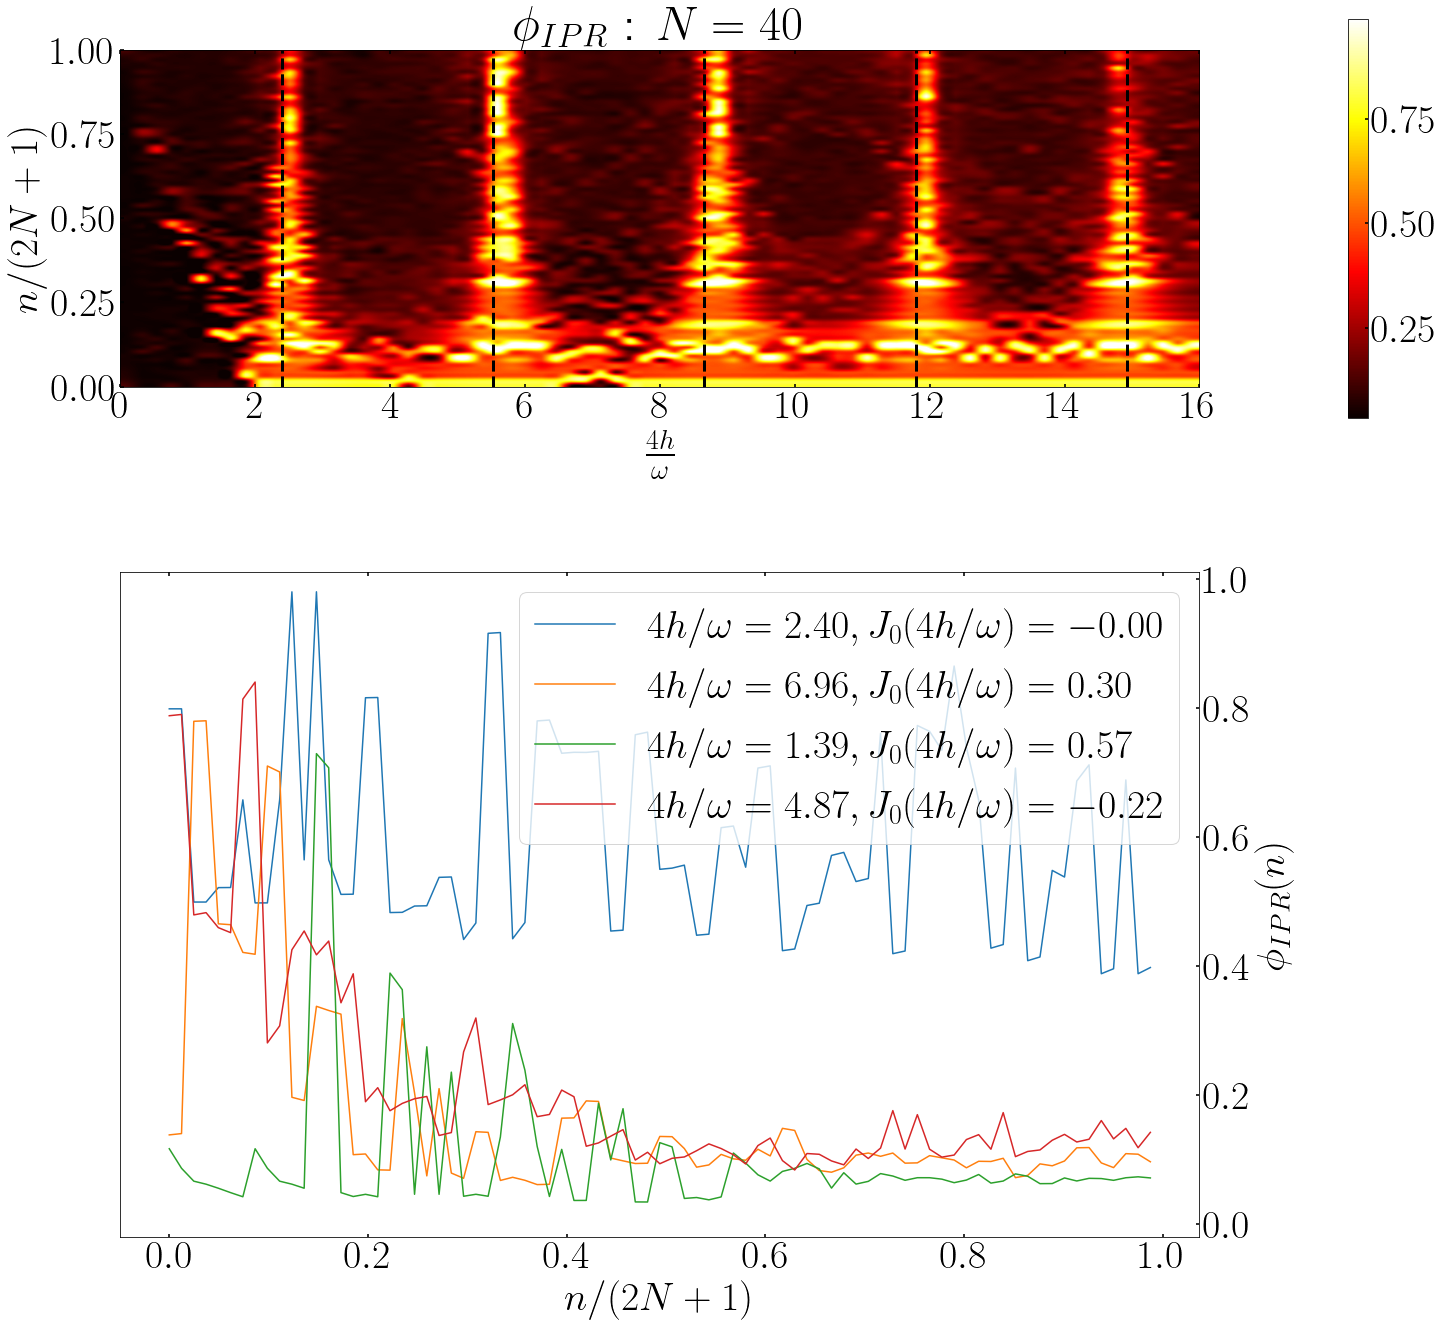

In [157]:
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline

from scipy.signal import savgol_filter

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})


from scipy.special import jn_zeros
freezing_pts = jn_zeros(0,5) + delta

etas = 4 * hs/w

fig = plt.figure(constrained_layout=True)

ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
ipr_ax.set_ylabel(r'$n/(2N+1)$')

for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='black', linestyle="--",linewidth=3.0)

im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.6)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[0], atol=0.03))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]+20

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.15))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 4.8, atol=0.15))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = np.arange(2*N+1)/(2*N+1)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
    crosssec_ax.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")


crosssec_ax.set_xlabel(r"$n/(2N+1)$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(n)$")
crosssec_ax.set_ylim(-0.02, 1.01)
plt.legend()
plt.show()

In [8]:
%%time
from qutip import Qobj, jmat, Options
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros

delta = 0.0
freezing_pts = jn_zeros(0,3)+delta
####################################################################################################
#
#                                     Exact Dynamics
#
####################################################################################################

N = 40
h0 = 0.0
omega = 90
nprocs = 14

w = omega

hsteps = 70
#h1 = (1/4) * omega * 0.01
h1 = 0
h2 = (1/4) * omega * 16.0 

hroots = freezing_pts * omega/4

hs = np.linspace(h1, h2, hsteps)

hs = np.sort(np.append(hs, hroots))

p = Pool(processes = nprocs)          
print("running for N = ", N, "with",nprocs,"processors")  

#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)
params = [{'h0':0, 'h':h, 'omega':omega, 'N':N, 'opts':opts} for h in hs]
f_stateslist = p.map(floq_evolv,tqdm(params, position=0, leave=True))


iprmat = np.zeros((len(hs),2*N+1))

sx = jmat(N,"x")
en, st = sx.eigenstates()

print("\n Done. Now calculating PR ...")
for xx,h in enumerate(hs):
    f_states = f_stateslist[xx]
    iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
print("Exact simulation complete!")


running for N =  40 with 14 processors


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 2209.98it/s]



 Done. Now calculating PR ...
Exact simulation complete!
CPU times: user 8.63 s, sys: 481 ms, total: 9.11 s
Wall time: 4min 57s


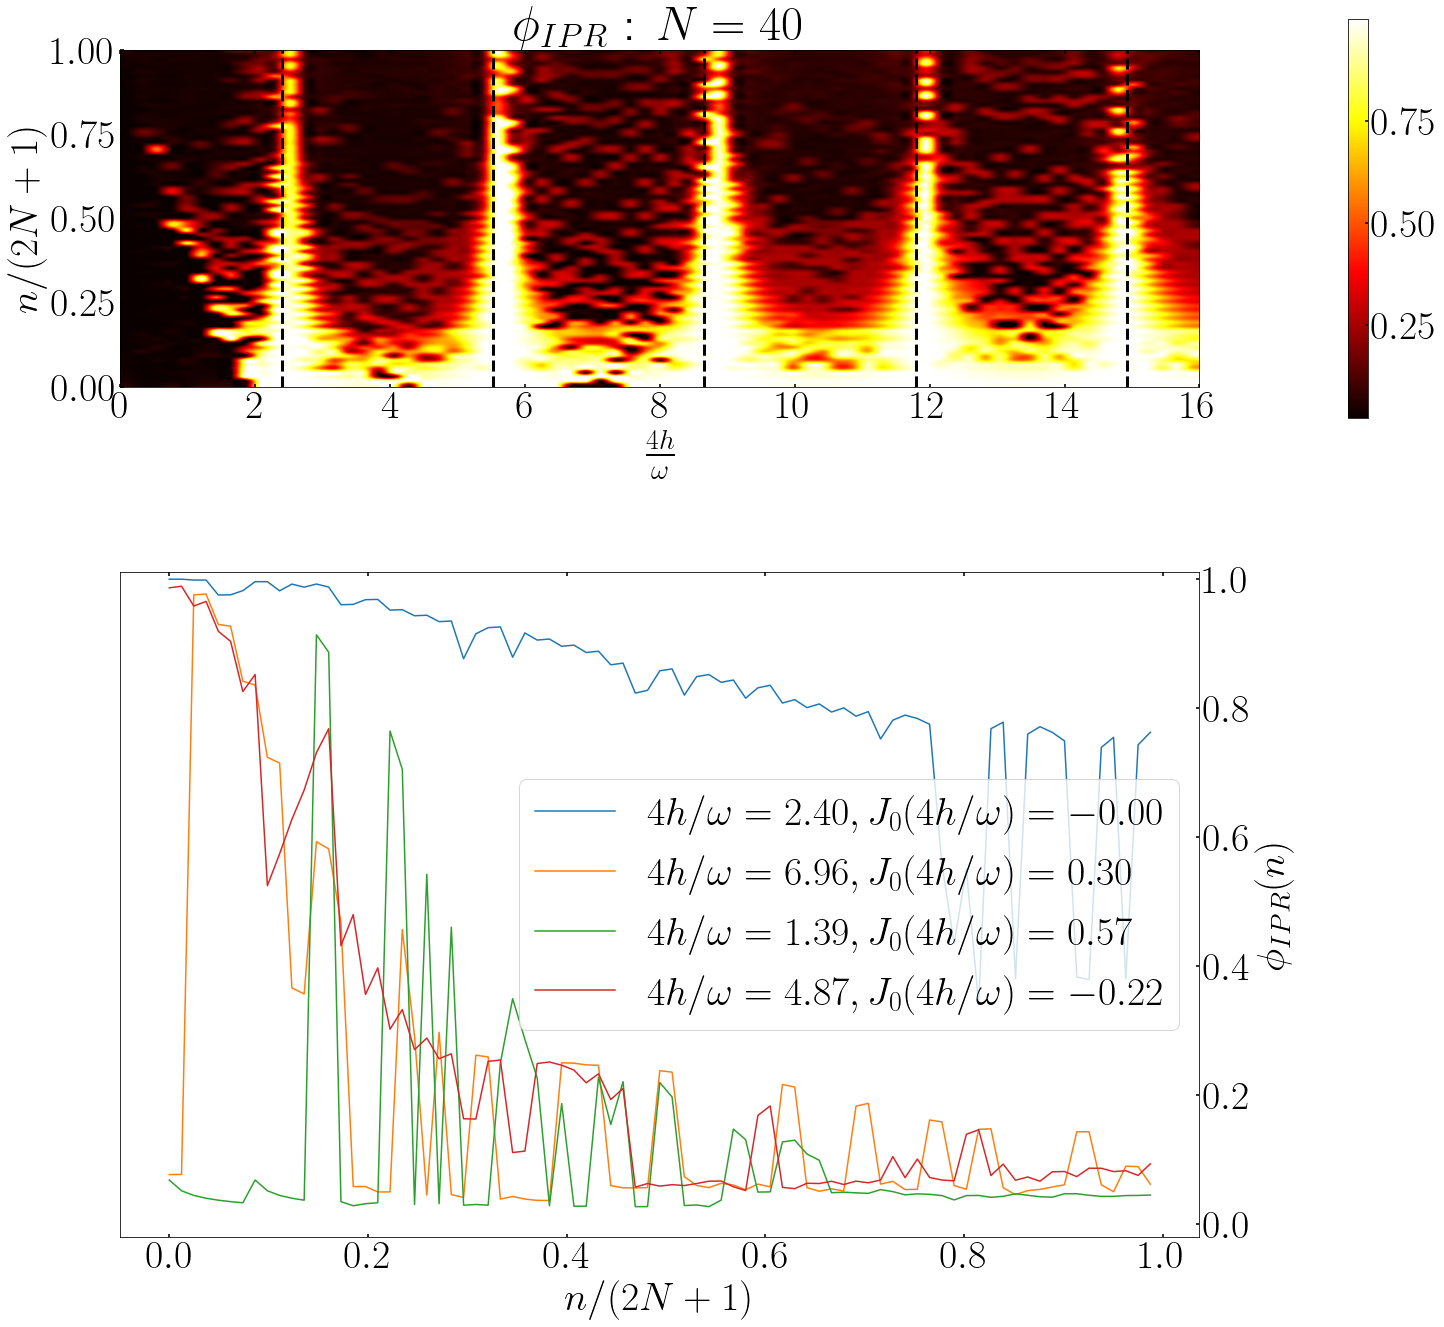

In [12]:
import matplotlib.pyplot as plt
from scipy.special import j0
from scipy.interpolate import make_interp_spline

from scipy.signal import savgol_filter

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 40,
    "font.sans-serif": ["Computer Modern"]})


from scipy.special import jn_zeros
freezing_pts = jn_zeros(0,5) + delta

etas = 4 * hs/w

fig = plt.figure(constrained_layout=True)

ipr_ax, crosssec_ax = fig.subplots(2,1)

ipr_ax.set_title(fr'$\phi_{{IPR}}$ : $N = {N}$')
# find minimum of minima & maximum of maxima
minmin = np.min(np.min(iprmat))
maxmax = np.max(np.max(iprmat))
asp = 5
ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
ipr_ax.set_ylabel(r'$n/(2N+1)$')

for pt in freezing_pts:
    ipr_ax.axvline(x=pt, color='black', linestyle="--",linewidth=3.0)

im = ipr_ax.imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

fig.colorbar(im, ax=ipr_ax, orientation='vertical', shrink=0.6)


#Freezing point
idx, = np.where(np.isclose(etas, freezing_pts[0], atol=0.03))
n0 = idx[0]

#High IPR
idx = np.where(iprmat[20:] == iprmat[20:].min())
n1 = idx[0][0]+20

#Intermediate IPR
idx, = np.where(np.isclose(etas, 1.5, atol=0.15))
n2 = idx[0]

#Another IPR
idx, = np.where(np.isclose(etas, 4.8, atol=0.15))
n3 = idx[0]

for i, n in enumerate([n0,n1, n2, n3]):
    xdata = np.arange(2*N+1)/(2*N+1)
    ydata =  iprmat[n]
    xnew = np.linspace(xdata.min(), xdata.max(), 300)
    gfg = make_interp_spline(xdata, ydata, k=3)
    #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
    crosssec_ax.plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")


crosssec_ax.set_xlabel(r"$n/(2N+1)$")
crosssec_ax.yaxis.tick_right()
crosssec_ax.yaxis.set_label_position("right")
crosssec_ax.set_ylabel(r"$\phi_{{IPR}}(n)$")
crosssec_ax.set_ylim(-0.02, 1.01)
plt.legend()
plt.show()

### Nature of the Floquet Hamiltonian

Here, we're looking at hinton plots of the matrix elements (in the $S^x$ representation) Floquet Hamiltonian $H_F$

CPU times: user 24.5 s, sys: 579 ms, total: 25.1 s
Wall time: 23.6 s


/usr/local/anaconda3/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


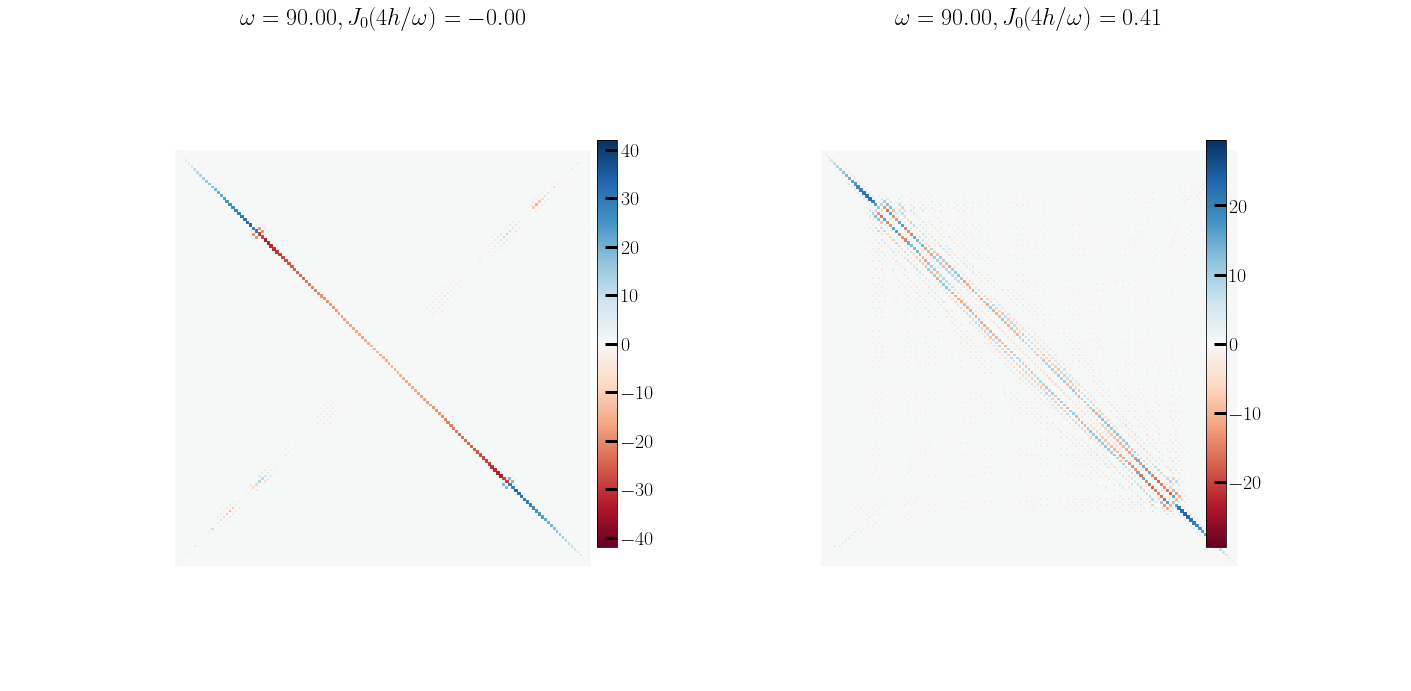

In [8]:
%%time
from qutip import Qobj, hinton, Options, jmat, matrix_histogram
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from scipy.special import jn_zeros, j0
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (20, 10),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 20,
    "font.sans-serif": ["Computer Modern"]})


freezing_pts = jn_zeros(0,3)
####################################################################################################
#
#                                     Exact Dynamics
#
####################################################################################################


N = 70
h0 = 0.0
# no anti-diagonal in frozen HF for w =80
# anti-diagonal appears in frozen HF for w =82

omega = 90
nprocs = 13

w = omega
T = 2.0 * np.pi/w

h_frz = freezing_pts[0] * omega/4
h_nfrz = 0.7 * h_frz

H0, H1 = get_hamiltonians(N)
H = [H0,[H1,drive]]
fig, axs = plt.subplots(1,2)
opts = Options(nsteps=1e5, num_cpus=13, openmp_threads=13)

params_frz = {'h0':0, 'h':h_frz, 'omega':w, 'N':N, 'opts':opts}
params_nfrz = {'h0':0, 'h':h_nfrz, 'omega':w, 'N':N, 'opts':opts}
sx = jmat(N,"x")
en, st = sx.eigenstates()

for i,p in enumerate([params_frz, params_nfrz]):
    h, w = p['h'], p['omega']
    f_modes, f_energies = floquet_modes_mod(H, T, args=p, parallel=True)
    HF = 0.
    for j, Omega in enumerate(f_energies):
        HF += Omega * f_modes[j].proj()
    
    HF = HF.transform(st)
    fig, ax = hinton(HF.tidyup(atol=1e-7), ax=axs[i], xlabels=False, ylabels=False)
    ax.set_title(r'$\omega = {:1.2f}, J_0(4h/\omega)={:1.2f} $'.format(w, j0(4*h/w)))
    

You can see noticeable anti-diagonal terms in $H_F$ in the $S^x$ representation when $J_0(4h/\omega)=0$. Thus, the Floquet Hamiltonian is NOT diagonal in this regime, contradicting the analytical assumption that only the lowest order term in the RWA counts in the dynamics. This is very different from the nearest-neighbour case when the lowest order term is all that it took.

### Conclusion
$S^x$ is mostly conserved and $H_F$ is **mostly** diagonal in the $S^x$ representation at freezing, the Floquet states have edge dips in their IPR's away from unity, almost certainly due to higher order effects in the RWA expansion. We can see this by looking at the RWA Hamiltonian to the next order.
# RWA to higher orders

The full Hamiltonian for the LMG model in the rotated basis is

\begin{equation}
\tilde{H}(t) = -\frac{4}{N}\Bigg[\frac{N}{2}\big(\frac{N}{2}+1\big) - \big(S^x\big)^2\Bigg]  -\frac{4}{N}\Big[\big(S^z\big)^2 - \big(S^y\big)^2\Big] \Bigg[\frac12 J_0(\eta) + \sum^\infty_{n=1}J_{2n}(\eta)\cos{\big(2n\omega t\big)}\Bigg] -\frac{4}{N} \big\{S^y, S^z \big\} \sum^\infty_{n=1}J_{2n-1}(\eta)\sin{\Big[\big(2n-1\big)\omega t\Big]}
\end{equation}

We can numerically obtain successive approximations for $H_F$ by truncating this series to higher orders in order to probe for the emergene of the anti-diagonal terms in $H_F$ in the $S^x$ representation.

In [3]:
import numpy as np
from qutip import jmat
from scipy.special import j0, jn

def drive_cos(t, args):
    n = args['order']
    w, h, h0 = args['omega'], args['h'], args['h0']
    eta = 4 * h /w
    idx = np.arange(0, n+1)
    cos_idx = idx[::2]
    return np.sum([jn(m,eta) * np.cos(m* w * t) for m in cos_idx]) - 0.5 * j0(eta)

def drive_sin(t, args):
    n = args['order']
    w, h, h0 = args['omega'], args['h'], args['h0']
    eta = 4 * h /w
    idx = np.arange(0, n+1)
    
    if n == 0:
        sin_idx = [0]
    elif n == 1:
        sin_idx = [0,1]
    else:
        sin_idx = idx[1::2]

    return np.sum([jn(m,eta) * np.sin(m* w * t) for m in sin_idx])


def get_hamiltonians_RWA(N, args):
    w = args['omega']
    h = args['h']
    sx,sy,sz = jmat(N,"x"),jmat(N,"y"),jmat(N,"z")
    kn =  2.0/N   
    H0 = -kn * (N/2 *(N/2+1) - sx*sx) 
    H1 = (-2* kn) * (sz*sz - sy*sy)
    H2 = -2 * kn * (sy*sz + sz*sy)
    return H0,H1, H2


def floq_evolv_RWA(args):
    N = args['N']
    h = args['h']
    T = 2 * np.pi/args['omega']
    opts = args['opts']
    order = args['order']
    H0, H1, H2 = get_hamiltonians_RWA(N,args)
    H = [H0,[H1,drive_cos], [H2, drive_sin]]
    f_states, _ = floquet_modes_mod(H, T, args=args)
        
    return f_states

print("Definitions complete!")

Definitions complete!


In [188]:
from qutip import Qobj, Options, jmat
import numpy as np
from scipy.special import j0, jn,jn_zeros

freezing_pts = jn_zeros(0,3)

N=3
h0 = 0.0
omega = 90
w = omega
T = 2.0 * np.pi/w
h_frz = freezing_pts[0] * omega/4
h_nfrz = 0.7 * h_frz

nprocs = 12
opts = Options(nsteps=1e5, num_cpus=nprocs, openmp_threads=1)

order = 0

params_frz = {'h0':0, 'h':h_frz, 'omega':w, 'N':N, 'opts':opts, 'order':order}
sx = jmat(N,"x")
en, st = (sx * sx).eigenstates()
evecs = floq_evolv_RWA(params_frz)

iprs = []

for vec in evecs:
    ipr = 0
    for estate in st:
        ipr += np.abs(vec.overlap(estate))**4
    iprs.append(ipr)    

iprs

[0.9999999999999996,
 0.9999999999999982,
 0.9999999999999969,
 1.0,
 0.9999999999999387,
 0.9999999999999982,
 0.9999999999999973]

In [182]:
[evecs[1].overlap(state) for state in st]

[(5.828670879282072e-16+0j),
 (0.7071067811865481+0j),
 0j,
 (-0.707106781186547+0j),
 (-6.106226635438361e-16+0j)]

In [171]:
evecs

array([Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
       Qobj data =
       [[-0.25      ]
        [ 0.5       ]
        [-0.61237244]
        [ 0.5       ]
        [-0.25      ]]                                              ,
       Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
       Qobj data =
       [[ 0.5]
        [-0.5]
        [ 0. ]
        [ 0.5]
        [-0.5]]                                                     ,
       Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
       Qobj data =
       [[ 0.61237244]
        [ 0.        ]
        [-0.5       ]
        [ 0.        ]
        [ 0.61237244]]                                              ,
       Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
       Qobj data =
       [[-0.5]
        [-0.5]
        [ 0. ]
        [ 0.5]
        [ 0.5]]                                                     ,
       Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
   

In [143]:
_, estates = np.linalg.eig(sx.full() @ sx.full())
estates

array([[ 3.53553391e-01-0.j,  7.07106781e-01+0.j,  6.12372436e-01-0.j,
        -0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [-0.00000000e+00+0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
         7.07106781e-01-0.j, -7.07106781e-01+0.j],
       [ 8.66025404e-01+0.j, -1.97275083e-16+0.j, -5.00000000e-01+0.j,
        -0.00000000e+00+0.j,  0.00000000e+00+0.j],
       [-0.00000000e+00+0.j, -0.00000000e+00+0.j, -0.00000000e+00+0.j,
         7.07106781e-01+0.j,  7.07106781e-01+0.j],
       [ 3.53553391e-01-0.j, -7.07106781e-01+0.j,  6.12372436e-01+0.j,
        -0.00000000e+00+0.j,  0.00000000e+00+0.j]])

In [138]:
sx.eigenstates()

(array([-2.0000000e+00, -1.0000000e+00,  8.8817842e-16,  1.0000000e+00,
         2.0000000e+00]),
 array([Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[-0.25      ]
         [ 0.5       ]
         [-0.61237244]
         [ 0.5       ]
         [-0.25      ]]                                              ,
        Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[ 0.5]
         [-0.5]
         [ 0. ]
         [ 0.5]
         [-0.5]]                                                     ,
        Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[ 0.61237244]
         [ 0.        ]
         [-0.5       ]
         [ 0.        ]
         [ 0.61237244]]                                              ,
        Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[-0.5]
         [-0.5]
         [ 0. ]
         [ 0.5]
         [ 0.5]] 

In [139]:
(sx * sx).eigenstates()

(array([1.52655666e-16, 1.00000000e+00, 1.00000000e+00, 4.00000000e+00,
        4.00000000e+00]),
 array([Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[ 0.61237244]
         [ 0.        ]
         [-0.5       ]
         [ 0.        ]
         [ 0.61237244]]                                              ,
        Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[ 0.70710678]
         [ 0.        ]
         [ 0.        ]
         [ 0.        ]
         [-0.70710678]]                                              ,
        Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[ 0.        ]
         [-0.70710678]
         [ 0.        ]
         [ 0.70710678]
         [ 0.        ]]                                              ,
        Quantum object: dims = [[5], [1]], shape = (5, 1), type = ket
        Qobj data =
        [[0.35355339]
         [0.        ]
         

In [165]:
A = np.random.random((3,3))
A = A + A.T
_, estates = np.linalg.eig(A)
display(_)
display(estates.T)
_, estates = np.linalg.eig(A @ A)
display(_)
display(estates.T)

array([ 3.47152785,  0.19009706, -0.5743202 ])

array([[-0.74883106, -0.4152453 , -0.5165495 ],
       [-0.57612854,  0.02258352,  0.81704705],
       [ 0.32760944, -0.90942912,  0.25614591]])

array([12.05150564,  0.03613689,  0.32984369])

array([[-0.74883106, -0.4152453 , -0.5165495 ],
       [-0.57612854,  0.02258352,  0.81704705],
       [ 0.32760944, -0.90942912,  0.25614591]])

In [166]:
estates @ estates.T

array([[ 1.00000000e+00, -8.32667268e-16,  1.24900090e-16],
       [-8.32667268e-16,  1.00000000e+00,  6.93889390e-16],
       [ 1.24900090e-16,  6.93889390e-16,  1.00000000e+00]])

CPU times: user 1min, sys: 2.52 s, total: 1min 2s
Wall time: 52.7 s


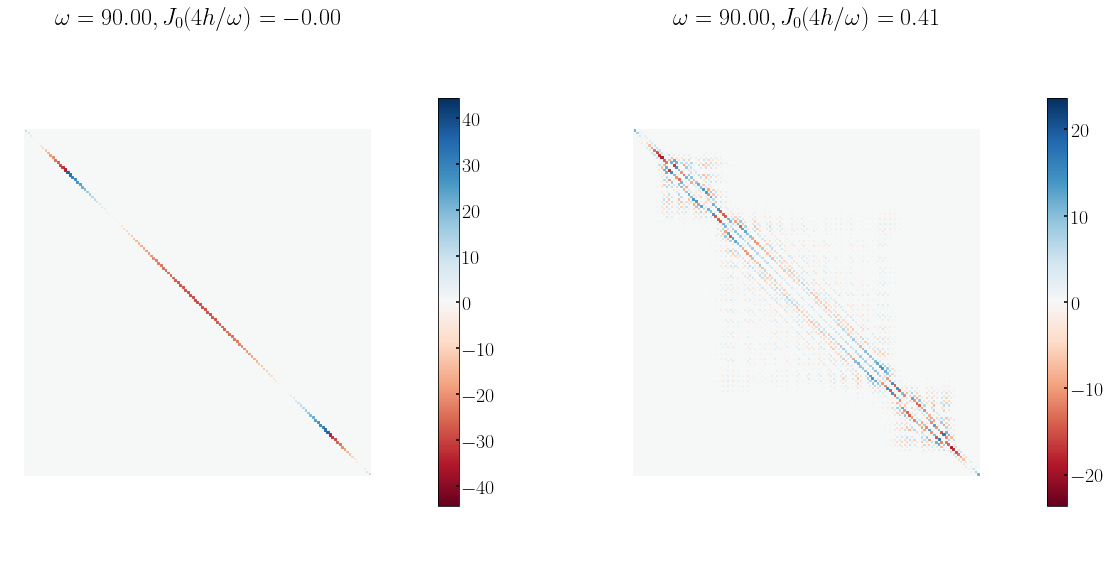

In [43]:
%%time
from qutip import Qobj, hinton, Options, jmat, matrix_histogram
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.special import j0, jn,jn_zeros
from numpy import angle, pi


plt.rcParams.update({
    "figure.figsize": (20, 10),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 20,
    "font.sans-serif": ["Computer Modern"]})


freezing_pts = jn_zeros(0,3)

N = 70
h0 = 0.0
omega = 90
w = omega
T = 2.0 * np.pi/w
h_frz = freezing_pts[0] * omega/4
h_nfrz = 0.7 * h_frz
U1-U
nprocs = 12
fig, axs = plt.subplots(1,2)
opts = Options(nsteps=1e5, num_cpus=nprocs, openmp_threads=1)

order = 0

params_frz = {'h0':0, 'h':h_frz, 'omega':w, 'N':N, 'opts':opts, 'order':order}
params_nfrz = {'h0':0, 'h':h_nfrz, 'omega':w, 'N':N, 'opts':opts, 'order':order}
sx = jmat(N,"x")
en, st = sx.eigenstates()

for i,p in enumerate([params_frz, params_nfrz]):
    H0,H1,H2 = get_hamiltonians_RWA(N, p)
    H = [H0,[H1,drive_cos], [H2, drive_sin]]
    h, w = p['h'], p['omega']
    f_modes, f_energies = floquet_modes_mod(H, T, args=p, parallel=True)
    HF = 0.
    for j, Omega in enumerate(f_energies):
        HF += Omega * f_modes[j].proj()
    
    HF = HF.transform(st)
    fig, ax = hinton(HF.tidyup(atol=1e-7), ax=axs[i], xlabels=False, ylabels=False)
    ax.set_title(r'$\omega = {:1.2f}, J_0(4h/\omega)={:1.2f} $'.format(w, j0(4*h/w)))

## Comparison of IPR: Exact with RWA

running for 2N+1 =  11 with 10 processors
running for order =  0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 39018.51it/s]


Done. Now calculating IPR ...
Exact simulation complete...
Now plotting...
running for order =  1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 43227.51it/s]


Done. Now calculating IPR ...
Exact simulation complete...
Now plotting...


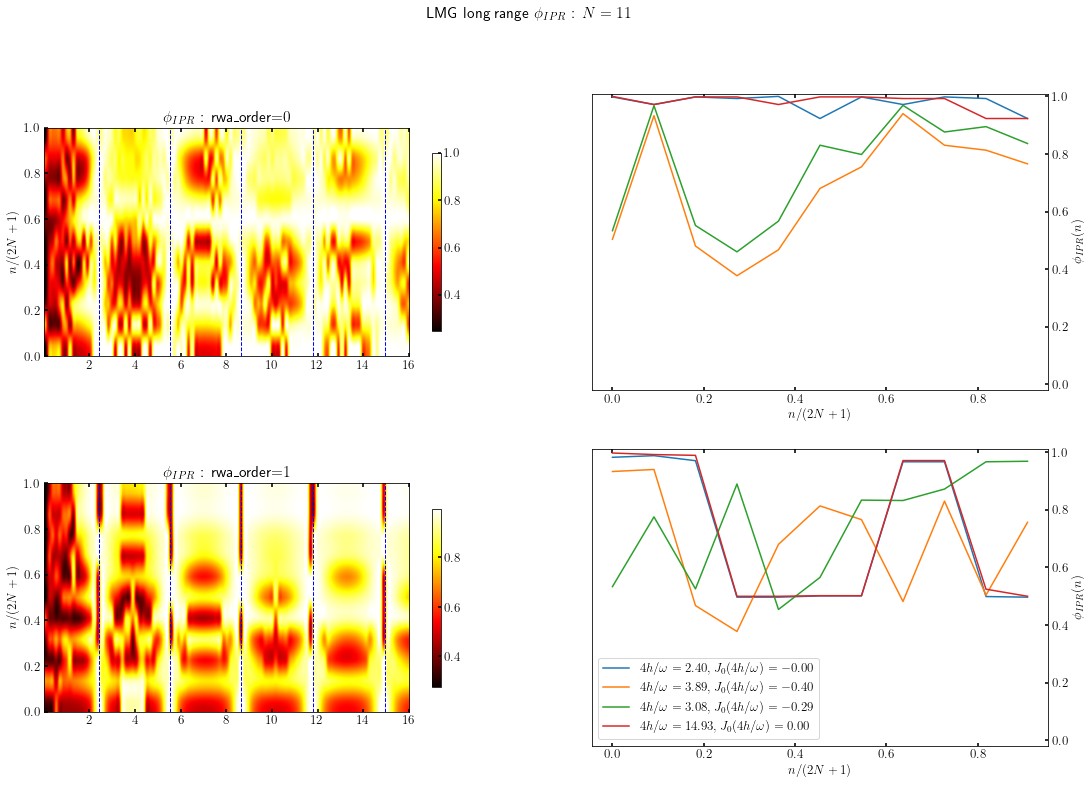

CPU times: user 3.38 s, sys: 126 ms, total: 3.5 s
Wall time: 4.1 s


In [148]:
%%time
import numpy as np
from numpy import angle, pi
from qutip import Options
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.special import j0, jn_zeros, jn

plt.rcParams.update({
    "figure.figsize": (20, 25),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 13,"font.sans-serif": ["Computer Modern"]})

delta = 0.0
freezing_pts = jn_zeros(0,5)+delta

N = 5
h0 = 0.0
omega = 90
nprocs = 10
orders = [0,1]
w = omega

hsteps = 100
h1 = (1/4) * omega * 0.01
h2 = (1/4) * omega * 16.0
hroots = freezing_pts * omega/4
hs = np.linspace(h1, h2, hsteps)
hs = np.sort(np.append(hs, hroots))

p = Pool(processes = nprocs)          
print("running for 2N+1 = ", 2*N+1, "with",nprocs,"processors")  
fig, axs = plt.subplots(len(orders), 2, figsize=(18,12))
fig.suptitle(fr'LMG long range $ \phi_{{IPR}}$ : $N = {2*N+1}$')

for i,order in enumerate(orders):
    print('running for order = ',order)
    
    opts = Options(nsteps=1e5, num_cpus=1, openmp_threads=1)
    params = [{'h0':0, 'h':h, 'omega':omega, 'N':N, 'order':order, 'opts':opts} for h in hs]
    f_stateslist = p.map(floq_evolv_RWA,tqdm(params, position=0, leave=True))

    iprmat = np.zeros((len(hs),2*N+1))
    sx = jmat(N,"x")
    en, st = (sx * sx).eigenstates()

    print("Done. Now calculating IPR ...")
    for xx,h in enumerate(hs):
        f_states = f_stateslist[xx]
        iprmat[xx,:] = [np.sum([np.abs(state.overlap(sx_ev))**4 for sx_ev in st]) for state in f_states]
    
    print("Exact simulation complete...")
    print("Now plotting...")

    etas = 4 * hs/w

    axs[i, 0].set_title(fr'$\phi_{{IPR}}$ : rwa_order=${order}$')
    # find minimum of minima & maximum of maxima
    minmin = np.min(np.min(iprmat))
    maxmax = np.max(np.max(iprmat))
    asp = 10
    #ipr_ax.set_xlabel(r'$\frac{4h}{\omega}$')
    axs[i, 0].set_ylabel(r'$n/(2N+1)$')

    for pt in freezing_pts:
        axs[i, 0].axvline(x=pt, color='blue', linestyle="--",linewidth=1.0)

    im = axs[i, 0].imshow(iprmat.T, aspect=asp, interpolation='spline16',\
                    cmap='hot', origin='lower',extent = [etas[0] , etas[-1], 0 , 1], vmax=maxmax, vmin=minmin)

    fig.colorbar(im, ax=axs[i, 0], orientation='vertical', shrink=0.6)


    #Freezing point
    idx, = np.where(np.isclose(etas, freezing_pts[0], atol=0.03))
    n0 = idx[0]

    #High IPR
    idx = np.where(iprmat[20:] == iprmat[20:].min())
    n1 = idx[0][0]+20

    #Intermediate IPR
    idx, = np.where(np.isclose(etas, 3.5, atol=0.5))
    n2 = idx[0]

    #Another IPR
    idx, = np.where(np.isclose(etas, freezing_pts[4], atol=0.005))
    n3 = idx[0]

    for j, n in enumerate([n0,n1, n2, n3]):
        xdata = np.arange(2*N+1)/(2*N+1)
        ydata =  iprmat[n]
        #xnew = np.linspace(xdata.min(), xdata.max(), 300)
        #gfg = make_interp_spline(xdata, ydata, k=3)
        #crosssec_ax.plot(xnew, gfg(xnew), label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")
        axs[i, 1].plot(xdata, ydata, label=fr"$4h/\omega={etas[n]:1.2f}, J_0(4h/\omega)={j0(etas[n]):1.2f}$")


    axs[i, 1].set_xlabel(r"$n/(2N+1)$")
    axs[i, 1].yaxis.tick_right()
    axs[i, 1].yaxis.set_label_position("right")
    axs[i, 1].set_ylabel(r"$\phi_{{IPR}}(n)$")
    axs[i, 1].set_ylim(-0.02, 1.01)
plt.legend()
plt.show()


# Classical Lipkin Dynamics

In the continuum limit, the Lipkin system can be described by the $p,q$ Hamiltonian:
\begin{equation*}
H = -2 q^2 - h(t)\;\sqrt{1-4q^2}\;\cos{p},
\end{equation*}
which yields the Hamiltonian dynamical system 
\begin{align*}
\frac{dq}{dt} &= h(t)\;\sqrt{1-4q^2}\;\sin{p}\\
\frac{dp}{dt} &= 4q\bigg[1-\frac{h(t)\cos{p}}{\sqrt{1-4q^2}}\bigg]
\end{align*}
Below are the Poincare sections (strobed at integer multiples of $T=2\pi/\omega$) of the ensuing dynamics for $h(t)=h\cos{\omega t}$ for two cases, one for which $J_0(4h/\omega)=0$ and one at lower value of $h$. These are compaared with the Husimi Q-functions of the Floquet States obtained as above. The quantum phase space is described by the *Spectral Average* of the Husimi functions of all the Floquet modes $|\phi^n\rangle$ for the chosen value of $S^2$, *i.e.* for a coherent state $|q, p\rangle$, we plot
\begin{equation*}
H(q,p)\equiv \frac{1}{\big(2N+1\big)\pi}\sum_n \langle q,p\vert \phi^n\rangle\langle\phi^n\vert q,p\rangle
\end{equation*}

These are shown for two cases, small $\omega$, where the classical plots are chaos dominated, and large $\omega$, where they are regular.

In [20]:
# Lipkin Model Cross-Section
import numpy as np
from scipy.integrate import odeint, odepack
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
from scipy.special import j0, jn_zeros
import warnings

warnings.filterwarnings("ignore")
from qutip import Options
from qutip.wigner import qfunc

# Maximum number of strobes
nmax = 1000
# Number of Processors
nprocs = 11

def lmg(z, t, h0, h, w):
    q, p = z
    drive = h0 + h * np.cos(w * t)
    sterm = np.sqrt(1.0 - 4.0 * q * q)
    qdot = drive * sterm * np.sin(p)
    pdot = 4.0 * q * (1.0 - (drive * np.cos(p)/sterm) )
    return [qdot, pdot]

def poincare_sec(x0, p0, nmax, args):
    h0, h, omega = args
    T = 2.0 * np.pi/omega
    t = T * np.arange(nmax)
    init = [x0,p0]
    points = odeint(lmg, init, t, args=args)
    points[:,1] = points[:,1] % (2.0 * np.pi)
    return points

plt.rcParams.update({
    "figure.figsize": (20, 20),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 20,
    "font.sans-serif": ["Computer Modern"]})

# Initial Conditions for classical poincare
n_ic = 15
init_x = np.linspace(-0.45, 0.45, n_ic)
near_zero = np.linspace(-0.01, 0.01, 10)
init_x = np.sort(np.append(init_x, near_zero))
init_p = np.linspace(0.0, 2.0 * np.pi, n_ic)
init_p = np.sort(np.append(init_p, [0.1, np.pi + 0.2]))
xv, pv = np.meshgrid(init_x, init_p, indexing='ij')

# Initial Conditions for quantum husimi
# Choose a size
N = 150
#Qutip Solver Options
opts = Options(nsteps=1e5, num_cpus=13, openmp_threads=13)
n_Q = 100
Q_qvals = np.linspace(-0.5, 0.5, n_Q)
Q_pvals = np.linspace(0.0, 2.0 * np.pi, n_Q)
Q_pvals = np.sort(np.append(Q_pvals, [0.1, np.pi + 0.2]))

Poincare section dynamics for h = 1.503015973559858 w = 2.5 with 11 processes ...
Done in 144.00769186019897 secs
Husimi plots for h = 1.503015973559858 w = 2.5 with 11 processes ...
Done in 20.00970721244812 secs
Poincare section dynamics for h = 54.10857504815489 w = 90.0 with 11 processes ...
Done in 147.22787857055664 secs
Husimi plots for h = 54.10857504815489 w = 90.0 with 11 processes ...
Done in 13.76294755935669 secs


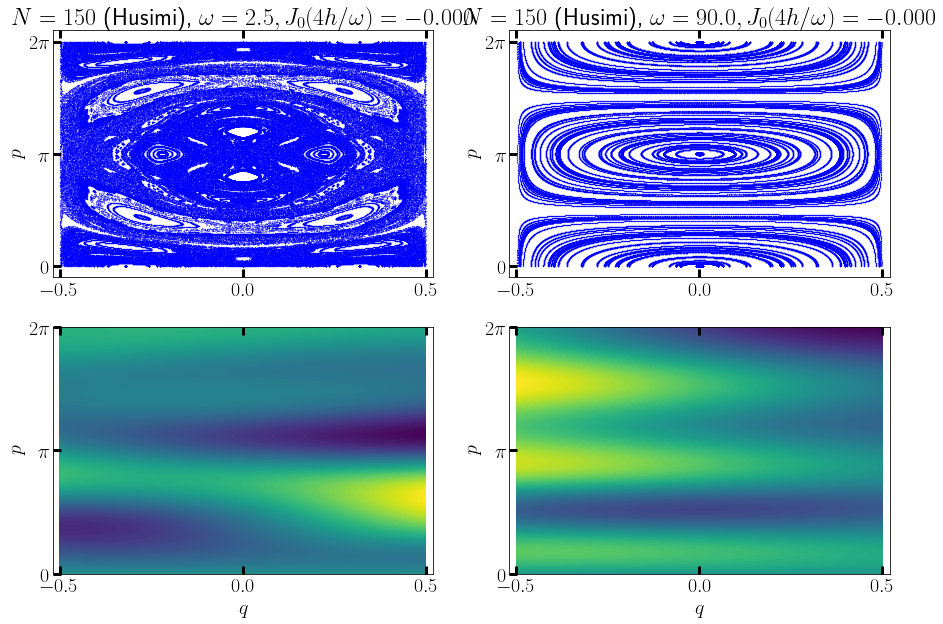

In [48]:
if __name__ == '__main__':
    # Drive parameters
    h0 = 0.0
    omegas = [2.5, 90.0]
    eta = jn_zeros(0,1)
    eta = eta[0]
    
    n_omegas = len(omegas)
    fig, axs = plt.subplots(2, n_omegas, figsize=(15, 10))

    for i, w in enumerate(omegas):
        h_frz = eta * w/4
        print(f"Poincare section dynamics for h = {h_frz} w = {w} with {nprocs} processes ...")   
        start = time.time()
        with Pool(processes = nprocs) as p:
            poincare_data = p.starmap(poincare_sec,[(x0, p0, nmax, (h0, h_frz, w)) for x0, p0 in zip(xv.flatten(), pv.flatten())])
        
        poincare_data = np.vstack(poincare_data)
        qvals = poincare_data[:,0]
        pvals = poincare_data[:,1]
        elapsed =  (time.time() - start)
        print(f"Done in {elapsed} secs")
        
        axs[0,i].set_title(r'$N={:d}$ (Husimi), $\omega = {:2.1f}, J_0(4 h/\omega) = {:1.3f}$'.format(N,w,j0(4*h_frz/w)))
        axs[0,i].scatter(qvals, pvals , color='blue', marker='.', s=.1)  
        
        #Now for the quantum case
        print(f"Husimi plots for h = {h_frz} w = {w} with {nprocs} processes ...")  
        start = time.time()
        params = {'h0':0, 'h':h_frz, 'omega':w, 'N':N, 'opts':opts} 
        H0, H1 = get_hamiltonians(N)
        H = [H0,[H1,drive]]
        T = 2 * np.pi/w
        evecs_f, _ = floquet_modes_mod(H, T, args=params)
        Q_fstate = 0
        for fstate in evecs_f:
            Q_fstate += qfunc(fstate, Q_qvals, Q_pvals)
        
        elapsed =  (time.time() - start)
        print(f"Done in {elapsed} secs")
        axs[1,i].contourf(Q_qvals, Q_pvals, Q_fstate/(2*N+1), 100)
        axs[1,i].set_xlabel(r'$q$')
    
    
    #Formatting
    x_tick = np.array([-0.5, 0.0, 0.5])
    unit   = 1.0
    p_tick = np.arange(0.0, 2.0 + unit, unit)
    p_label = [r"$0$", r"$\pi$", r"$2\pi$"]
    
    for ax in axs.flatten():
        ax.set_xticks(x_tick)
        ax.set_xlim(-0.52, 0.52)
        ax.set_yticks(p_tick*np.pi, p_label)
        ax.set_ylabel(r"$p$")
        ax.tick_params(direction='in', length=8, width=3)
    
    #plt.savefig("lmg_poincare01.svg")
    plt.show()

## Conservation of $S^x$ at freezing, classical and quantum

Here, we compare the quantum evolution of $\langle S^x\rangle$ (both in and out of freezing) with the evolution of $s_x = \sqrt{1-4q^2}\cos{p}$ in the classical case. For the moment, we're choosing random initial conditions for both cases. Below are plots of the relative evolution $\big(\langle S^x(t)\rangle-\langle S^x(0)\rangle\big)/\langle S^x(0)\rangle$ of the quantum case, contrasted with the relative evolution of the classical $\big(s_x(t) -s_x(0)\big)/s_x(0)$, with the drive frequency $\omega=90$ and the amplitude $h$ adjusted both for the freezing case ($J_0(4h/\omega)=0$, lowest root) and out of freezing, with $J_0(4h/\omega)\neq 0$.

CPU times: user 612 ms, sys: 281 ms, total: 893 ms
Wall time: 3min 26s


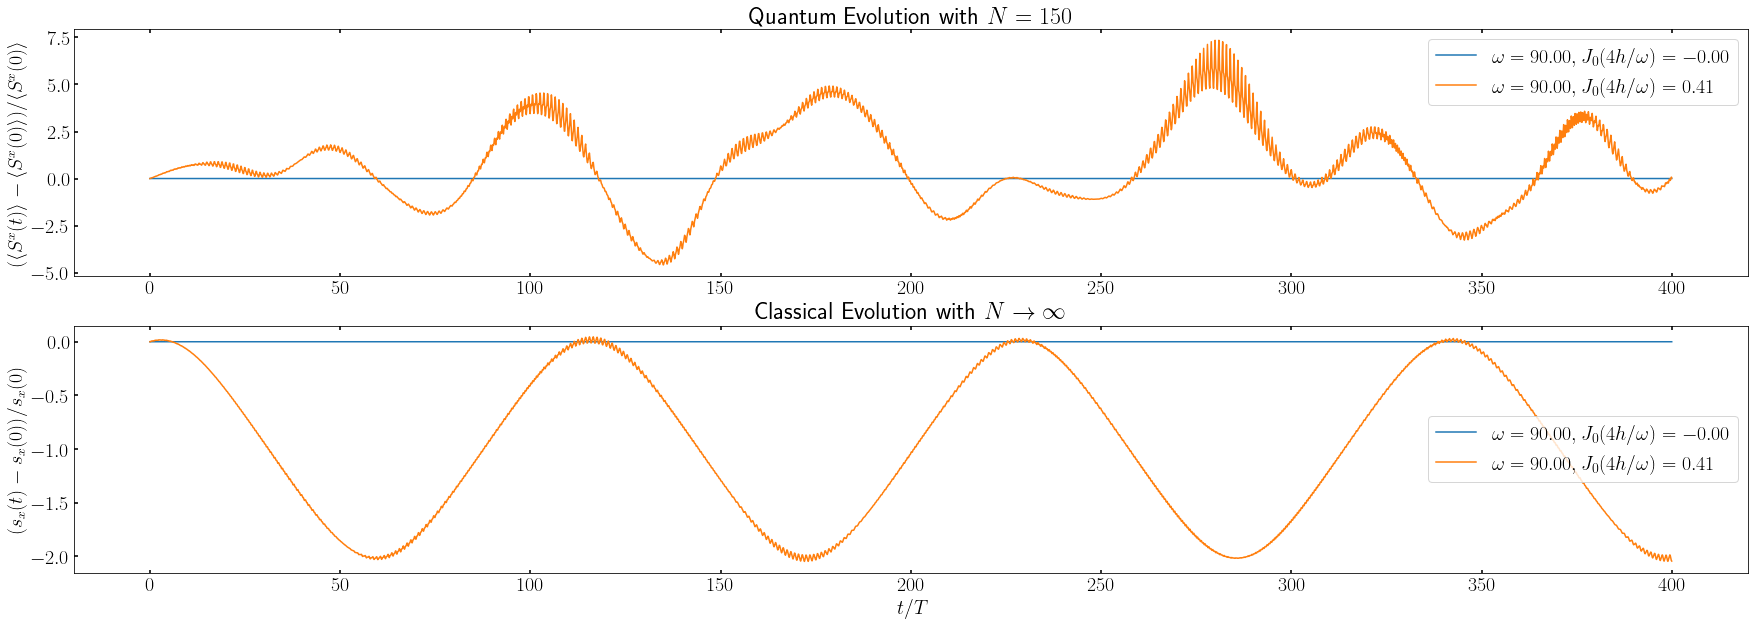

In [25]:
%%time
from qutip import Options, mesolve, rand_ket, parfor
import numpy as np
from scipy.special import jn_zeros
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (12, 12),
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 20,
    "font.sans-serif": ["Computer Modern"]})

N = 150
h0 = 0.0
omega = 90
nprocs = 13

fig, (ax_q, ax_c) = plt.subplots(2, 1, figsize=(30, 10))
ax_q.set_title(r"Quantum Evolution with $N={:d}$".format(N))
ax_c.set_title(r"Classical Evolution with $N\rightarrow\infty$")

freezing_pts = jn_zeros(0,3)
psi0 = rand_ket(2*N+1)
qinit = np.random.uniform(-0.5, 0.5)
pinit = np.random.uniform(0.0, 2 * np.pi)
nt = 400
times = np.linspace(0.0, nt*T, nt*10)


def classical_evolve(args):
    h, w = args['h'], args['omega']
    T = 2.0 * np.pi/w
    init = [qinit,pinit]
    p = (0.0, h, w)
    points = odeint(lmg, init, times, args=p)
    points[:,1] = points[:,1] % (2.0 * np.pi)
    qvals, pvals = points[:,0], points[:,1]
    return times/T, np.sqrt(1-4*qvals*qvals) * np.cos(pvals)

def quantum_evolve(args):
    h, w = args['h'], args['omega']
    result = mesolve(H, psi0, times,args=args, e_ops=jmat(N,"x")/N)
    T = 2 * np.pi/w
    return times/T, result.expect[0]

w = omega
T = 2.0 * np.pi/w

h_frz = freezing_pts[0] * w/4
h_nfrz = 0.7 * h_frz

H0, H1 = get_hamiltonians(N)
H = [H0,[H1,drive]]

#Qutip Solver Options
opts = Options(nsteps=1e7, num_cpus=2, openmp_threads=1)
params_frz = {'h0':0, 'h':h_frz, 'omega':w, 'N':N, 'opts':opts}
params_nfrz = {'h0':0, 'h':h_nfrz, 'omega':w, 'N':N, 'opts':opts}

params_arr = [params_frz, params_nfrz]

times_arr, sxq_arr = parfor(quantum_evolve, params_arr)
times_arr, sxc_arr = parfor(classical_evolve, params_arr)

for j, p in enumerate(params_arr):
    h, w = p['h'], p['omega']
    ax_q.plot(times/T, (sxq_arr[j]-sxq_arr[0])/sxq_arr[0], label=r'$\omega = {:2.2f}, J_0(4h/\omega)={:1.2f}$'.format(w, j0(4*h/w)))
    ax_c.plot(times/T, (sxc_arr[j]-sxc_arr[0])/sxc_arr[0], label=r'$\omega = {:2.2f}, J_0(4h/\omega)={:1.2f}$'.format(w, j0(4*h/w)))
    
ax_q.set_ylabel(r'$\big(\langle S^x(t)\rangle - \langle S^x(0)\rangle\big)/\langle S^x(0)\rangle$')
ax_c.set_ylabel(r'$\big(s_x(t) - s_x(0)\big)/s_x(0)$')

ax_c.set_xlabel(r'$t/T$')
#ax_q.set_ylim(-50,50)
#ax_c.set_ylim(-5,5)

ax_q.legend()
ax_c.legend()